The whole notebook takes around **2 minutes** to complete on a machine with Intel(R) Core(TM) i7-8550U CPU @ 1.80GHz.

In [1]:
import itertools

import numpy as np
import scipy.stats as ss
import statsmodels.stats.multitest as mt
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.notebook import tqdm # progress bars

import peca

# Terrorist attacks

In [2]:
date_range = pd.date_range("2015-01-01", "2017-12-31", freq="1D")

In [3]:
# Download GTD from https://www.start.umd.edu/gtd/
# We use the 2014-2017 data set

#gtd = pd.read_csv("/path/to/gtd_14to17_0718dist.csv", low_memory=False)
gtd = pd.read_csv("/home/erik/Documents/data/globalterrorism-start/gtd_14to17_0718dist.csv", low_memory=False)
gtd = gtd.join(pd.to_datetime(gtd[["iyear", "imonth", "iday"]].rename({"iyear": "year", "imonth": "month", "iday": "day"}, axis="columns")).rename("date"))

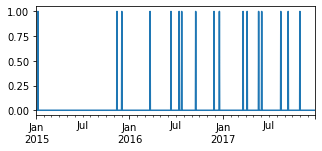

WENA-10: 17 days with events. (Several entries at the same day are viewed as a single event.)

0 2015-01-07 Paris France 12.0 12.0
1 2015-11-13 Saint Denis France 34.0 2.0
2 2015-11-13 Paris France 26.0 15.0
3 2015-11-13 Saint Denis France 34.0 1.0
4 2015-11-13 Paris France 24.0 5.0
5 2015-11-13 Paris France 26.0 19.0
6 2015-11-13 Paris France 18.0 1.0
7 2015-11-13 Paris France 217.0 93.0
8 2015-11-13 Saint Denis France 34.0 1.0
9 2015-12-02 San Bernardino United States 17.0 16.0
10 2016-03-22 Zaventem Belgium 135.0 18.0
11 2016-03-22 Brussels Belgium 135.0 17.0
12 2016-06-12 Orlando United States 53.0 50.0
13 2016-07-14 Nice France 433.0 87.0
14 2016-07-24 Ansbach Germany 15.0 1.0
15 2016-09-17 New York City United States 29.0 0.0
16 2016-09-17 St. Cloud United States 10.0 1.0
17 2016-11-28 Columbus United States 11.0 1.0
18 2016-12-19 Berlin Germany 48.0 12.0
19 2017-03-22 London United Kingdom 50.0 6.0
20 2017-04-07 Stockholm Sweden 14.0 5.0
21 2017-05-22 Manchester United Kingdom 1

In [4]:
cols = ["date", "country_txt", "city", "nkill", "nwound", "gname"]

sel_islamist = ((gtd["gname"] == "Al-Qaida in the Arabian Peninsula (AQAP)")
                | (gtd["gname"] == "Islamic State of Iraq and the Levant (ISIL)")
                | (gtd["gname"] == "Jihadi-inspired extremists")
                | (gtd["gname"] == "Muslim extremists"))
sel_wena = ((gtd["region_txt"] == "Western Europe")
                | (gtd["region_txt"] == "North America"))
sel_mena = ((gtd["region_txt"] == "Middle East & North Africa"))
sel_min10wound = (gtd["nwound"] >= 10)

index = gtd.loc[
          sel_islamist
        & sel_wena
        & sel_min10wound
            ][cols].groupby("date").sum().index.copy()
eventseries = pd.Series(index=index, data=[1]*len(index), name="GTD").reindex(date_range).fillna(0)
eventseries.plot(figsize=(5,2))
plt.show()

E = eventseries.values
N_E = E.sum()

print("WENA-10: %d days with events. (Several entries at the same day are viewed as a single event.)" % eventseries.sum())
print("")
for i, r in enumerate(gtd[sel_wena & sel_islamist & sel_min10wound].itertuples()):
    print(i, r.date.date(), r.city, r.country_txt, r.nwound, r.nkill)

# Twitter volume

In [5]:
timeseries_daily = pd.read_csv("twitter-volume.csv", index_col=0, parse_dates=[0])

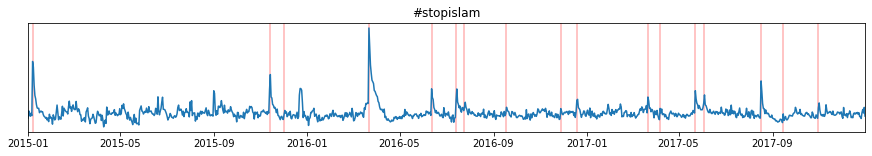

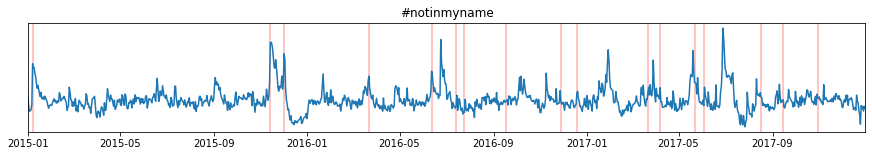

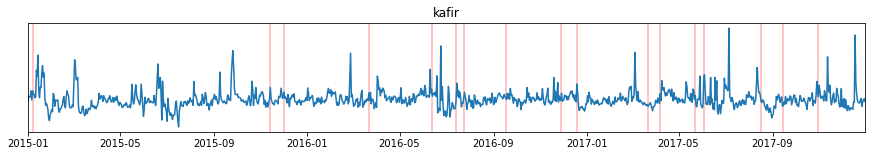

In [6]:
for c in timeseries_daily.columns:
    # preprocessing
    data = np.log2(timeseries_daily[c].copy()+1)
    data = data - data.rolling(window=30).mean()
    data = data.loc[date_range]

    plt.figure(figsize=(15,2))
    plt.title(c)
    for d in eventseries[eventseries == 1].index:
        plt.axvline(d, color="red", alpha=0.3)
    plt.plot(data)
    plt.xlim((date_range[0],date_range[-1]))
    plt.yticks([])
    plt.show()

# Analyses

In [7]:
delta = 7

## Section 4.3. Examples.

#### Test whether Islamist terrorist attacks systematically trigger bursts of more than 1,000 posts per day on Twitter that contain the hashtag #stopislam.

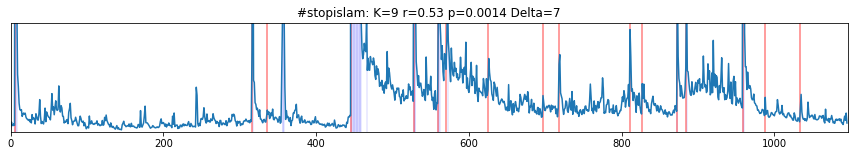

In [8]:
# NOTE: the raw time series used in this example is not stationary

c = "#stopislam"
X = timeseries_daily[c].loc[date_range].values
thresh = 1000
taus = np.array([thresh]) # must be np.array for numba speed-up

K_tr       = peca.tcp(X, E, delta, taus)
tcp_params = peca.tcp_params_fit(X, delta, taus)
pval       = peca.tcp_marginal_pval(K_tr, N_E, tcp_params)

plt.figure(figsize=(15,2))
plt.title("%s: K=%d r=%.2f p=%.4f Delta=%d" % (c, K_tr, K_tr/E.sum(), pval, delta))
for i in np.where(X > thresh)[0]:
    plt.axvline(i, color="blue", alpha=0.1)
for i in np.where(E == 1)[0]:
    plt.axvline(i, color="red", alpha=0.5)
plt.plot(X)
plt.xlim(0, len(X))
plt.yticks([])
plt.ylim((0,thresh))
plt.show()

#### Test the hypothesis that Islamist terrorist attacks systematically trigger bursts of #notinmyname usage that exceed the volume of 95% of all days.

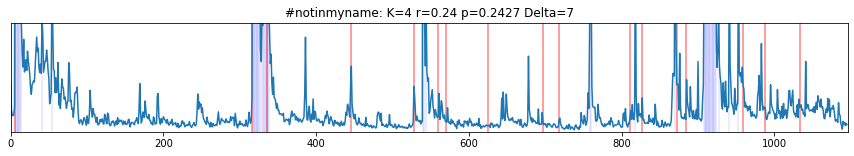

In [9]:
# NOTE: the raw time series used in this example is not stationary

c = "#notinmyname"
X = timeseries_daily[c].loc[date_range].values
thresh = np.percentile(X, 95)
taus = np.array([thresh]) # must be np.array for numba speed-up

K_tr       = peca.tcp(X, E, delta, taus)
tcp_params = peca.tcp_params_fit(X, delta, taus)
pval       = peca.tcp_marginal_pval(K_tr, N_E, tcp_params)

plt.figure(figsize=(15,2))
plt.title("%s: K=%d r=%.2f p=%.4f Delta=%d" % (c, K_tr, K_tr/E.sum(), pval, delta))
for i in np.where(X > thresh)[0]:
    plt.axvline(i, color="blue", alpha=0.1)
for i in np.where(E == 1)[0]:
    plt.axvline(i, color="red", alpha=0.5)
plt.plot(X)
plt.xlim(0, len(X))
plt.yticks([])
plt.ylim((0,thresh))
plt.show()

# Section 5

In [10]:
rhos = np.linspace(0.75, 1, 32)
delta = 7
simuls = 10000
alpha = 0.05

In [11]:
X = {c: None for c in timeseries_daily.columns}
taus = {c: None for c in timeseries_daily.columns}
tcp_params = {c: None for c in timeseries_daily.columns}
simul_nlls = {c: None for c in timeseries_daily.columns}
simul_seqs = {c: None for c in timeseries_daily.columns}

for c in timeseries_daily.columns:
    data = np.log2(timeseries_daily[c].copy()+1)
    data = data - data.rolling(window=30).mean()
    data = data.loc[date_range]

    X[c] = data.values
    taus[c] = np.percentile(X[c],rhos*100)
    tcp_params[c] = peca.tcp_params_fit(X[c], delta, taus[c])

    # Monte carlo simulations for statistical significance
    simul_nlls[c] = np.zeros(simuls)
    simul_seqs[c] = [None] * simuls
    for s in tqdm(range(simuls), total=simuls, desc=c):
        simul_E = np.random.permutation(E)
        simul_seqs[c][s] = peca.tcp(X[c], simul_E, delta, taus[c])
        simul_nlls[c][s] = peca.tcp_nll(simul_seqs[c][s], N_E, tcp_params[c])

Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


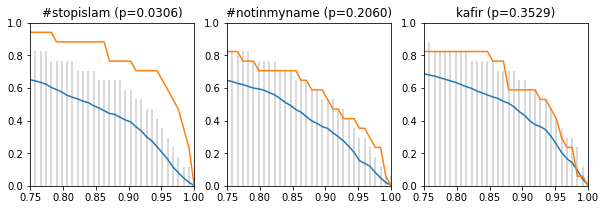

In [12]:
plt.figure(figsize=(10,3))
for i, c in enumerate(timeseries_daily.columns):
    K_tr = peca.tcp(X[c], E, delta, taus[c])
    nll  = peca.tcp_nll(K_tr, N_E, tcp_params[c])
    pval = (np.sum(simul_nlls[c] >= nll)+1)/(simuls+1) # Monte Carlo p-value of observed nll value

    plt.subplot(1,3,i+1)
    plt.plot(rhos, peca.tcp_marginal_expectation(N_E, tcp_params[c])/N_E)
    plt.vlines(rhos, np.zeros_like(rhos), ss.binom.ppf(1-alpha, N_E, tcp_params[c][0])/N_E, alpha=0.2)
    plt.plot(rhos, K_tr/N_E)
    plt.xlim((rhos[0], rhos[-1]))
    plt.ylim((0,1))
    plt.title("%s (p%c%.4f)" % (c,
                    ('='  if pval > 0.0001 else '<'),
                    (pval if pval > 0.0001 else 0.0001)))
plt.show()

#### Alternative: Multiple hypothesis testing approach with pointwise $p$-values

In [14]:
for i, c in enumerate(timeseries_daily.columns):
    K_tr = peca.tcp(X[c], E, delta, taus[c])
    pvals = peca.tcp_marginal_pval(K_tr, N_E, tcp_params[c])
    print(c)
    for method in ["b", "s", "hs", "h"]:
        reject, pvals_adj, _, _ = mt.multipletests(pvals, alpha=alpha, method=method)
        print("   ", method, "\t", "reject" if reject.any() else "no reject", "(p=%.4f)" % pvals_adj.min())

#stopislam
    b 	 reject (p=0.0007)
    s 	 reject (p=0.0007)
    hs 	 reject (p=0.0007)
    h 	 reject (p=0.0007)
#notinmyname
    b 	 no reject (p=0.2754)
    s 	 no reject (p=0.2417)
    hs 	 no reject (p=0.2417)
    h 	 no reject (p=0.2754)
kafir
    b 	 no reject (p=0.6706)
    s 	 no reject (p=0.4922)
    hs 	 no reject (p=0.4922)
    h 	 no reject (p=0.6706)
